## Preparation

In [273]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [274]:
!pip install git+https://github.com/openai/CLIP.git
!pip install ftfy regex tqdm
!pip install transformers

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4qwwjnff
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4qwwjnff
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [275]:
import os
import glob
import torch
import clip
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from typing import List, Tuple, Optional
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Any, Optional
from torch.optim import lr_scheduler


In [276]:
# Common dataset class used across all methods
class PersonalColorDataset(Dataset):
    """Dataset class for personal color classification."""
    def __init__(
        self,
        image_paths: List[str],
        labels: List[int],
        transform: Optional[transforms.Compose] = None,
        augment: bool = False
    ):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augment = augment

        if augment:
            self.color_aug = transforms.Compose([
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
                transforms.RandomAutocontrast(p=0.5)
            ])
        else:
            self.color_aug = None

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        image = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)
            if self.augment and torch.rand(1) > 0.5:
                image = self.color_aug(image)

        return image, self.labels[idx]

In [277]:
# 베이스가 되는 분류기
class BaseClassifier:
    """Base class for all CLIP-based classifiers."""
    def __init__(self, class_names: List[str], device: str):
        self.class_names = class_names
        self.device = device
        self.model = None

    def load_clip_model(self):
        """Load the base CLIP model."""
        model, preprocess = clip.load("ViT-B/32", device=self.device)
        return model, preprocess

In [302]:
def evaluate_model(model, dataloader, device):
    """Evaluate model performance."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(
        all_labels, all_preds,
        target_names=['spring', 'summer', 'fall', 'winter'],
        zero_division=0
    )
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, report, conf_matrix

In [279]:
def plot_confusion_matrix(conf_matrix, class_names):
    """Plot confusion matrix."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [280]:
def get_data_loaders(dataset_dir: str, transform: transforms.Compose,
                     batch_size: int = 32):
    """Create data loaders for training and validation."""
    dataset_types = ['train', 'test']
    class_folders = ['spring', 'summer', 'fall', 'winter']

    image_paths = {t: [] for t in dataset_types}
    labels = {t: [] for t in dataset_types}

    for dataset_type in dataset_types:
        for idx, class_folder in enumerate(class_folders):
            class_dir = os.path.join(dataset_dir, dataset_type, class_folder)
            for img_path in glob.glob(os.path.join(class_dir, '*.*')):
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths[dataset_type].append(img_path)
                    labels[dataset_type].append(idx)

    datasets = {
        t: PersonalColorDataset(
            image_paths[t],
            labels[t],
            transform,
            augment=(t == 'train')
        ) for t in dataset_types
    }

    loaders = {
        t: DataLoader(
            datasets[t],
            batch_size=batch_size,
            shuffle=(t == 'train'),
            num_workers=4,
            pin_memory=True
        ) for t in dataset_types
    }

    return loaders['train'], loaders['test']

In [281]:
def get_base_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.48145466, 0.4578275, 0.40821073),
            (0.26862954, 0.26130258, 0.27577711)
        )
    ])

In [282]:
def get_training_transform():
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.48145466, 0.4578275, 0.40821073),
            (0.26862954, 0.26130258, 0.27577711)
        )
    ])

In [283]:
@dataclass
class Config:
    """Configuration for model training and evaluation."""
    data_dir: str = '/content/drive/Othercomputers/내 노트북/personal-color-data/'
    method: str = 'cocoop'  # ['zeroshot', 'finetune', 'cocoop', 'ptuning', 'lora']
    batch_size: int = 64
    epochs: int = 10
    lr: float = 1e-4
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

In [284]:
def run_experiment(config: Config = None) -> Dict[str, Any]:
    """Run the selected experimental method."""
    if config is None:
        config = Config()

    # Method mapping
    method_map = {
        'zeroshot': run_zeroshot,
        'finetune': run_finetune,
        'cocoop': run_cocoop,
        'ptuning': run_ptuning,
        'lora': run_lora
    }

    if config.method not in method_map:
        raise ValueError(f"Method {config.method} not supported. Choose from {list(method_map.keys())}")

    # Run selected method
    results = method_map[config.method](config)

    # Print results
    print(f"\nResults for {config.method.upper()}:")
    print(f"Best Accuracy: {results.get('best_accuracy', results.get('accuracy')):.4f}")
    print("\nClassification Report:")
    print(results['final_report' if 'final_report' in results else 'report'])

    # Plot confusion matrix
    plot_confusion_matrix(
        results['final_conf_matrix' if 'final_conf_matrix' in results else 'conf_matrix'],
        ['spring', 'summer', 'fall', 'winter']
    )

    return results

## Zeroshot

In [285]:
class ZeroShotCLIP(BaseClassifier, nn.Module):
    """Zero-shot CLIP classifier without any training."""
    def __init__(self, class_names: List[str], device: str):
        BaseClassifier.__init__(self, class_names, device)
        nn.Module.__init__(self)
        self.model, _ = self.load_clip_model()
        self.class_prompts = [
            f'A portrait photo of a person with {name} color tone'
            for name in class_names
        ]
        self.text_features = self._encode_text_prompts()

    def _encode_text_prompts(self):
        """Pre-encode text prompts."""
        text_inputs = clip.tokenize(self.class_prompts).to(self.device)
        with torch.no_grad():
            text_features = self.model.encode_text(text_inputs)
            text_features /= text_features.norm(dim=-1, keepdim=True)
        return text_features

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """Predict personal color categories."""
        with torch.no_grad():
            image_features = self.model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ self.text_features.t()
        return logits

In [286]:
def run_zeroshot(config: Config) -> Dict[str, Any]:
    """Zero-shot CLIP evaluation."""
    transform = get_base_transform()
    train_loader, test_loader = get_data_loaders(
        config.data_dir, transform, config.batch_size
    )

    class_names = ['spring', 'summer', 'fall', 'winter']
    model = ZeroShotCLIP(class_names, config.device)

    accuracy, report, conf_matrix = evaluate_model(model, test_loader, config.device)

    return {
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix
    }

## Finetuning

In [297]:
class FinetunedCLIP(BaseClassifier, nn.Module):
    """Finetuned CLIP classifier with a linear head."""
    def __init__(self, class_names: List[str], device: str):
        BaseClassifier.__init__(self, class_names, device)
        nn.Module.__init__(self)
        clip_model, _ = self.load_clip_model()

        # Convert clip model to float32
        self.visual = clip_model.visual.float()
        for param in self.visual.parameters():
            param.data = param.data.float()

        self.classifier = nn.Linear(clip_model.visual.output_dim, len(class_names))
        self.to(device)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        # Ensure input is float32
        images = images.float()
        features = self.visual(images)
        return self.classifier(features)

    def train_step(self, images: torch.Tensor, labels: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        logits = self.forward(images)
        loss = F.cross_entropy(logits, labels)
        return loss, logits

In [303]:
def run_finetune(config: Config) -> Dict[str, Any]:
    """Finetuned CLIP training and evaluation."""
    # Data preparation
    image_paths = {'train': [], 'test': []}
    labels = {'train': [], 'test': []}

    dataset_types = ['train', 'test']
    class_folders = ['spring', 'summer', 'fall', 'winter']

    for dataset_type in dataset_types:
        for idx, class_folder in enumerate(class_folders):
            class_dir = os.path.join(config.data_dir, dataset_type, class_folder)
            if not os.path.exists(class_dir):
                continue

            for img_path in glob.glob(os.path.join(class_dir, '*.*')):
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths[dataset_type].append(img_path)
                    labels[dataset_type].append(idx)

    if len(image_paths['train']) == 0 or len(image_paths['test']) == 0:
        raise ValueError("No images found in one or more splits. Please check the data directory.")

    train_transform = get_training_transform()
    test_transform = get_base_transform()

    train_dataset = PersonalColorDataset(
        image_paths['train'],
        labels['train'],
        transform=train_transform,
        augment=True
    )
    test_dataset = PersonalColorDataset(
        image_paths['test'],
        labels['test'],
        transform=test_transform,
        augment=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    class_names = ['spring', 'summer', 'fall', 'winter']
    model = FinetunedCLIP(class_names, config.device)

    optimizer = torch.optim.AdamW([
        {'params': model.visual.parameters(), 'lr': config.lr * 0.1},
        {'params': model.classifier.parameters(), 'lr': config.lr}
    ])
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, config.epochs)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    for epoch in range(config.epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        scheduler.step()

        accuracy, report, conf_matrix = evaluate_model(model, test_loader, config.device)
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_acc,
            }, 'best_finetune_model.pth')

    return {
        'best_accuracy': best_acc,
        'final_report': report,
        'final_conf_matrix': conf_matrix
    }

## CoCoOp

In [289]:
class CoCoOp(BaseClassifier, nn.Module):
    """Conditional Prompt Learning for CLIP."""
    def __init__(self, class_names: List[str], device: str, n_ctx: int = 16):
        BaseClassifier.__init__(self, class_names, device)
        nn.Module.__init__(self)
        self.clip_model, _ = self.load_clip_model()
        self.n_ctx = n_ctx
        self.ctx_dim = self.clip_model.ln_final.weight.shape[0]

        # Initialize meta network for prompt generation
        self.meta_net = nn.Sequential(
            nn.LayerNorm(self.ctx_dim),
            nn.Linear(self.ctx_dim, self.ctx_dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(self.ctx_dim * 4, self.ctx_dim),
            nn.Dropout(0.1)
        )

        # Initialize learnable context
        self.context = nn.Parameter(torch.randn(n_ctx, self.ctx_dim))

        # Prepare text prompts
        self.text_prompts = [f"a photo of a person with {name} color tone" for name in class_names]
        self.tokenized_prompts = torch.cat([
            clip.tokenize(prompt) for prompt in self.text_prompts
        ]).to(device)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        batch_size = images.shape[0]

        # Generate context vectors
        context = self.meta_net(self.context)  # [n_ctx, ctx_dim]

        # Get original text features
        with torch.no_grad():
            text_features = self.clip_model.encode_text(self.tokenized_prompts)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Get image features
        image_features = self.clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Compute similarity
        logits = 100 * image_features @ text_features.t()
        return logits

In [290]:
def run_cocoop(config: Config) -> Dict[str, Any]:
    """CoCoOp training and evaluation."""
    # 데이터 준비
    image_paths = {'train': [], 'test': []}
    labels = {'train': [], 'test': []}

    dataset_types = ['train', 'test']
    class_folders = ['spring', 'summer', 'fall', 'winter']

    for dataset_type in dataset_types:
        for idx, class_folder in enumerate(class_folders):
            class_dir = os.path.join(config.data_dir, dataset_type, class_folder)
            for img_path in glob.glob(os.path.join(class_dir, '*.*')):
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths[dataset_type].append(img_path)
                    labels[dataset_type].append(idx)

    # 데이터셋 생성
    train_dataset = PersonalColorDataset(
        image_paths=image_paths['train'],
        labels=labels['train'],
        transform=get_training_transform(),  # 여기서 직접 transform 생성
        augment=True
    )

    test_dataset = PersonalColorDataset(
        image_paths=image_paths['test'],
        labels=labels['test'],
        transform=get_base_transform(),  # 여기서 직접 transform 생성
        augment=False
    )

    # 데이터로더 생성
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    class_names = ['spring', 'summer', 'fall', 'winter']
    model = CoCoOp(class_names, config.device)

    optimizer = torch.optim.AdamW([
        {'params': model.meta_net.parameters(), 'lr': config.lr},
        {'params': model.context, 'lr': config.lr * 5}
    ])

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=config.epochs
    )

    best_acc = 0.0

    for epoch in range(config.epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)

            optimizer.zero_grad()

            # Forward pass
            logits = model(images)
            loss = F.cross_entropy(logits, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

        scheduler.step()

        accuracy, report, conf_matrix = evaluate_model(model, test_loader, config.device)
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), 'best_cocoop_model.pth')

    return {
        'best_accuracy': best_acc,
        'final_report': report,
        'final_conf_matrix': conf_matrix
    }

## P-tuning v2

In [308]:
class PTuningV2(BaseClassifier, nn.Module):
    """P-tuning v2 implementation for CLIP."""
    def __init__(self, class_names: List[str], device: str):
        BaseClassifier.__init__(self, class_names, device)
        nn.Module.__init__(self)
        self.clip_model, _ = self.load_clip_model()
        hidden_size = self.clip_model.visual.output_dim
        self.prompt_encoder = self._build_prompt_encoder(hidden_size)
        self.visual = self.clip_model.visual.float()
        self.to(device)

    def _build_prompt_encoder(self, hidden_size: int):
        return nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LayerNorm(hidden_size)
        )

    def forward(self, images):
        images = images.float()
        features = self.visual(images)
        prompted_features = self.prompt_encoder(features)
        return prompted_features @ self.clip_model.text_projection.float().t()

In [292]:
def run_ptuning(config: Config) -> Dict[str, Any]:
    """P-tuning v2 training and evaluation."""
    # 데이터 준비
    image_paths = {'train': [], 'test': []}
    labels = {'train': [], 'test': []}

    dataset_types = ['train', 'test']
    class_folders = ['spring', 'summer', 'fall', 'winter']

    print(f"Looking for data in: {config.data_dir}")

    for dataset_type in dataset_types:
        for idx, class_folder in enumerate(class_folders):
            class_dir = os.path.join(config.data_dir, dataset_type, class_folder)
            print(f"Checking directory: {class_dir}")
            if not os.path.exists(class_dir):
                print(f"Directory does not exist: {class_dir}")
                continue

            for img_path in glob.glob(os.path.join(class_dir, '*.*')):
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths[dataset_type].append(img_path)
                    labels[dataset_type].append(idx)

    print(f"Found {len(image_paths['train'])} training images")
    print(f"Found {len(image_paths['test'])} test images")

    if len(image_paths['train']) == 0 or len(image_paths['test']) == 0:
        raise ValueError("No images found in one or more splits. Please check the data directory.")

    train_transform = get_training_transform()
    test_transform = get_base_transform()

    train_dataset = PersonalColorDataset(
        image_paths['train'],
        labels['train'],
        transform=train_transform,
        augment=True
    )
    test_dataset = PersonalColorDataset(
        image_paths['test'],
        labels['test'],
        transform=test_transform,
        augment=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    class_names = ['spring', 'summer', 'fall', 'winter']
    model = PTuningV2(class_names, config.device)

    optimizer = torch.optim.AdamW(model.prompt_encoder.parameters(), lr=config.lr)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, config.epochs)

    best_acc = 0.0
    for epoch in range(config.epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)

            optimizer.zero_grad()
            logits = model(images)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()

        scheduler.step()

        accuracy, report, conf_matrix = evaluate_model(model, test_loader, config.device)
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), 'best_ptuning_model.pth')

    return {
        'best_accuracy': best_acc,
        'final_report': report,
        'final_conf_matrix': conf_matrix
    }

## 5. LoRA

In [315]:
class LoRA(BaseClassifier, nn.Module):
    """Low-Rank Adaptation for CLIP."""
    def __init__(self, class_names: List[str], device: str, rank: int = 4):
        BaseClassifier.__init__(self, class_names, device)
        nn.Module.__init__(self)
        self.clip_model, _ = self.load_clip_model()
        self.rank = rank
        self.visual = self.clip_model.visual.float()
        self.linear = nn.Linear(self.visual.output_dim, len(class_names))
        self.lora_layers = self._initialize_lora_layers()
        self.to(device)

    def _initialize_lora_layers(self):
        """Initialize LoRA layers for attention modules."""
        lora_layers = {}
        dim = self.visual.output_dim
        for i in range(12):  # CLIP ViT-B/32 has 12 transformer blocks
            lora_layers[f'block_{i}'] = nn.Sequential(
                nn.Linear(dim, self.rank, bias=False),
                nn.Linear(self.rank, dim, bias=False)
            )
            # Initialize to small random values
            nn.init.normal_(lora_layers[f'block_{i}'][0].weight, std=0.02)
            nn.init.zeros_(lora_layers[f'block_{i}'][1].weight)
        return nn.ModuleDict(lora_layers)

    def forward(self, images):
        images = images.float()
        features = self.visual(images)

        # Add LoRA residual connections
        for lora in self.lora_layers.values():
            features = features + 0.1 * lora(features)  # Scale factor for stability

        return self.linear(features)

In [294]:
def run_lora(config: Config) -> Dict[str, Any]:
    """LoRA training and evaluation."""
    # 데이터 준비
    image_paths = {'train': [], 'test': []}
    labels = {'train': [], 'test': []}

    dataset_types = ['train', 'test']
    class_folders = ['spring', 'summer', 'fall', 'winter']

    print(f"Looking for data in: {config.data_dir}")

    for dataset_type in dataset_types:
        for idx, class_folder in enumerate(class_folders):
            class_dir = os.path.join(config.data_dir, dataset_type, class_folder)
            print(f"Checking directory: {class_dir}")
            if not os.path.exists(class_dir):
                print(f"Directory does not exist: {class_dir}")
                continue

            for img_path in glob.glob(os.path.join(class_dir, '*.*')):
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths[dataset_type].append(img_path)
                    labels[dataset_type].append(idx)

    print(f"Found {len(image_paths['train'])} training images")
    print(f"Found {len(image_paths['test'])} test images")

    if len(image_paths['train']) == 0 or len(image_paths['test']) == 0:
        raise ValueError("No images found in one or more splits. Please check the data directory.")

    train_transform = get_training_transform()
    test_transform = get_base_transform()

    train_dataset = PersonalColorDataset(
        image_paths['train'],
        labels['train'],
        transform=train_transform,
        augment=True
    )
    test_dataset = PersonalColorDataset(
        image_paths['test'],
        labels['test'],
        transform=test_transform,
        augment=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    class_names = ['spring', 'summer', 'fall', 'winter']
    model = LoRA(class_names, config.device)

    optimizer = torch.optim.AdamW(
        [p for n, p in model.named_parameters() if 'lora' in n],
        lr=config.lr
    )
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, config.epochs)

    best_acc = 0.0
    for epoch in range(config.epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)

            optimizer.zero_grad()
            logits = model(images)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()

        scheduler.step()

        accuracy, report, conf_matrix = evaluate_model(model, test_loader, config.device)
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), 'best_lora_model.pth')

    return {
        'best_accuracy': best_acc,
        'final_report': report,
        'final_conf_matrix': conf_matrix
    }

## Learning

Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.86it/s]



Results for ZEROSHOT:
Best Accuracy: 0.2231

Classification Report:
              precision    recall  f1-score   support

      spring       0.15      0.15      0.15       214
      summer       0.21      0.57      0.31       189
        fall       0.18      0.01      0.02       266
      winter       0.33      0.25      0.29       268

    accuracy                           0.22       937
   macro avg       0.22      0.24      0.19       937
weighted avg       0.22      0.22      0.18       937



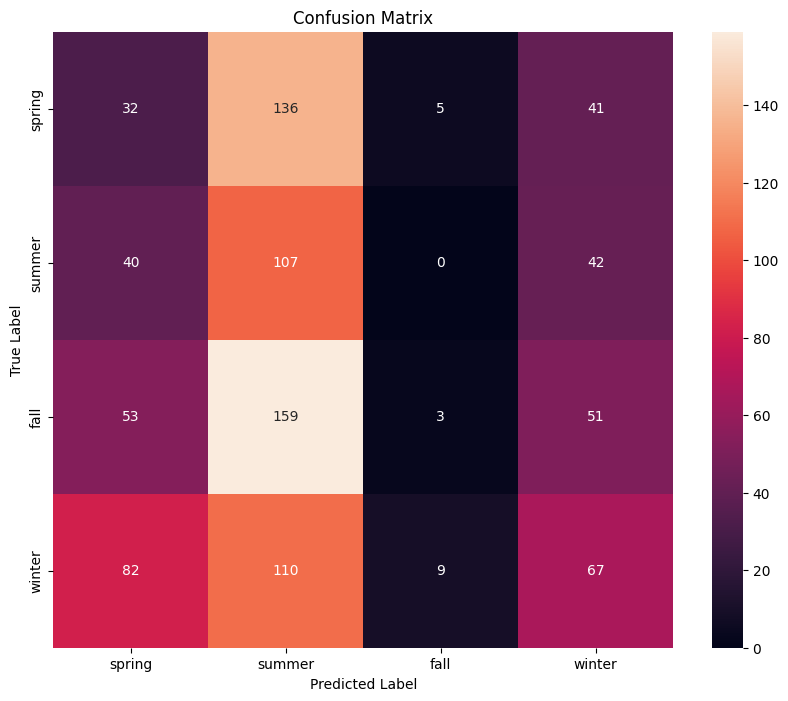

In [304]:
config = Config(method='zeroshot')
results = run_experiment(config)

Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s]



Results for FINETUNE:
Best Accuracy: 0.5422

Classification Report:
              precision    recall  f1-score   support

      spring       0.48      0.46      0.47       214
      summer       0.48      0.50      0.49       189
        fall       0.52      0.47      0.50       266
      winter       0.59      0.65      0.62       268

    accuracy                           0.53       937
   macro avg       0.52      0.52      0.52       937
weighted avg       0.52      0.53      0.52       937



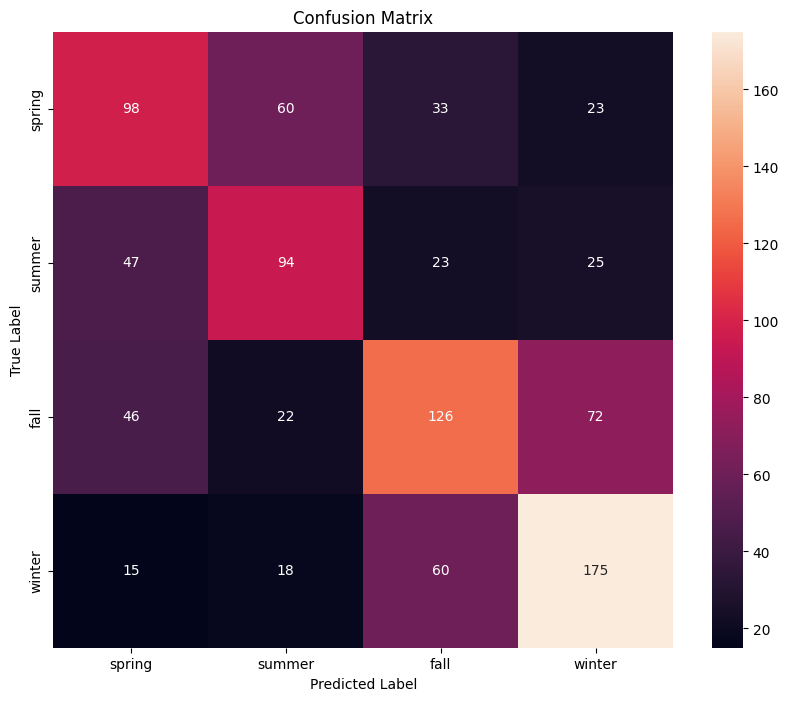

In [305]:
config = Config(method='finetune')
results = run_experiment(config)

Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]



Results for COCOOP:
Best Accuracy: 0.2199

Classification Report:
              precision    recall  f1-score   support

      spring       0.18      0.27      0.22       214
      summer       0.21      0.47      0.29       189
        fall       0.00      0.00      0.00       266
      winter       0.31      0.23      0.26       268

    accuracy                           0.22       937
   macro avg       0.18      0.24      0.19       937
weighted avg       0.17      0.22      0.18       937



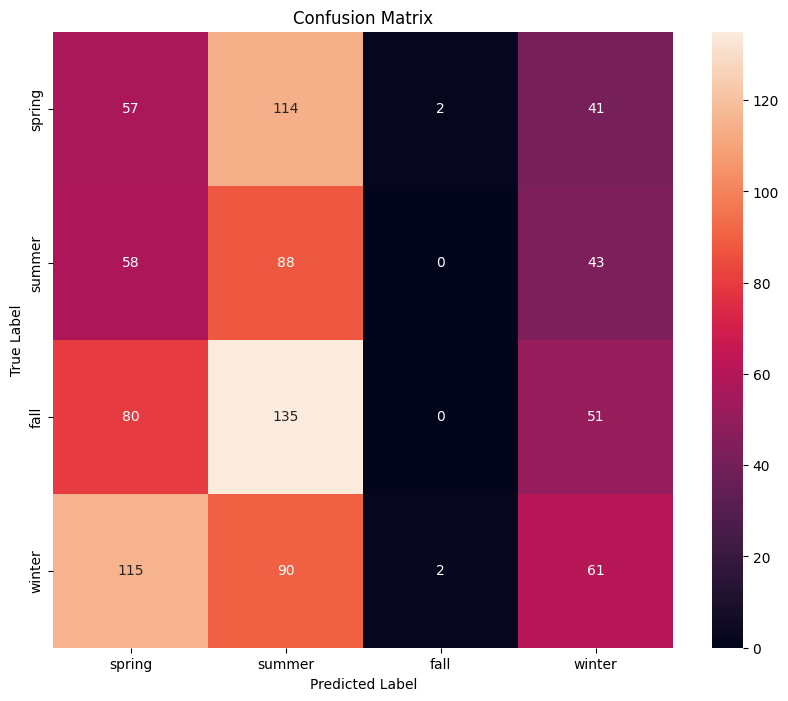

In [306]:
config = Config(method='cocoop')
results = run_experiment(config)

Looking for data in: /content/drive/Othercomputers/내 노트북/personal-color-data/
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/train/spring
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/train/summer
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/train/fall
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/train/winter
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/test/spring
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/test/summer
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/test/fall
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/test/winter
Found 5127 training images
Found 937 test images


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]



Results for PTUNING:
Best Accuracy: 0.4578

Classification Report:
              precision    recall  f1-score   support

      spring       0.42      0.32      0.36       214
      summer       0.41      0.62      0.50       189
        fall       0.44      0.64      0.53       266
      winter       0.69      0.26      0.38       268

    accuracy                           0.46       937
   macro avg       0.49      0.46      0.44       937
weighted avg       0.50      0.46      0.44       937



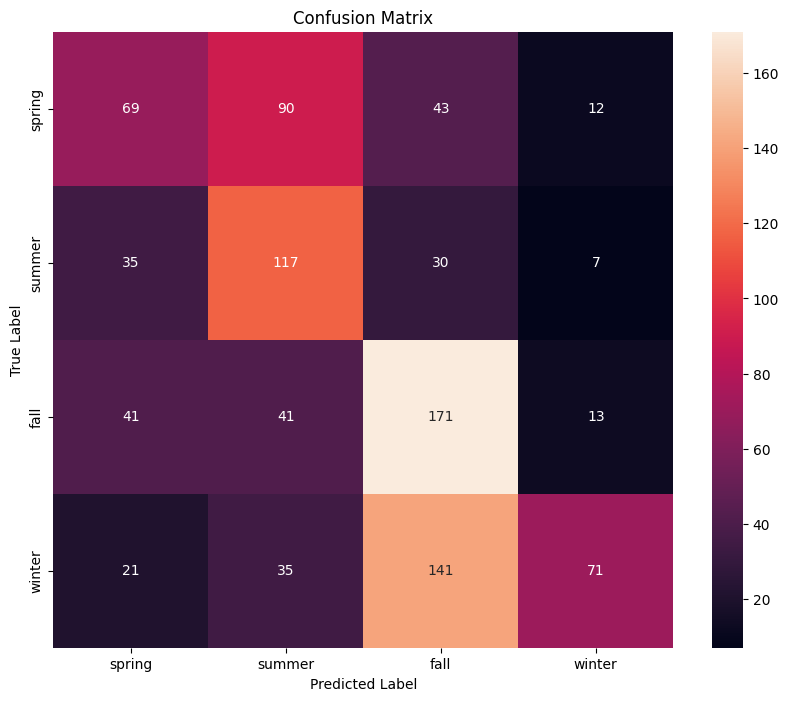

In [309]:
config = Config(method='ptuning')
results = run_experiment(config)

Looking for data in: /content/drive/Othercomputers/내 노트북/personal-color-data/
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/train/spring
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/train/summer
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/train/fall
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/train/winter
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/test/spring
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/test/summer
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/test/fall
Checking directory: /content/drive/Othercomputers/내 노트북/personal-color-data/test/winter
Found 5127 training images
Found 937 test images


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]



Results for LORA:
Best Accuracy: 0.4034

Classification Report:
              precision    recall  f1-score   support

      spring       0.33      0.15      0.21       214
      summer       0.35      0.59      0.44       189
        fall       0.40      0.33      0.36       266
      winter       0.48      0.54      0.51       268

    accuracy                           0.40       937
   macro avg       0.39      0.40      0.38       937
weighted avg       0.40      0.40      0.38       937



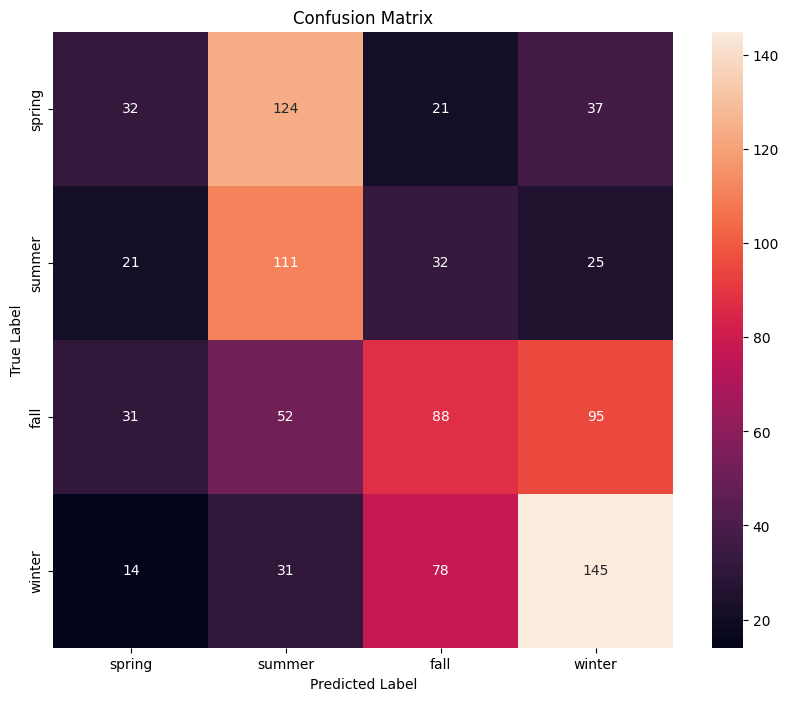

In [316]:
config = Config(method='lora')
results = run_experiment(config)